In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 读取数据
df = pd.read_csv('../data/train.csv')
print("数据集形状:", df.shape)
print("\n前5行数据预览:")
df.head()


数据集形状: (84000, 24)

前5行数据预览:


,id,loanAmnt,term,interestRate,installment,grade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,ficoRangeHigh,openAcc,pubRec,pubRecBankruptcies,revolBal,revolUtil,totalAcc,applicationType,policyCode,isDefault
0,0,35000,5,19.52,917.97,E,320,2 years,2,110000.0,...,734,7,0,0.0,24178,48.9,27,0,1,1
1,1,18000,5,18.49,461.90,D,219843,5 years,0,46000.0,...,704,13,0,0.0,15096,38.9,18,0,1,0
2,2,12000,5,16.99,298.17,D,31698,8 years,0,74000.0,...,679,11,0,0.0,4606,51.8,27,0,1,0
3,3,11000,3,7.26,340.96,A,46854,10+ years,1,118000.0,...,689,9,0,0.0,9948,52.6,28,0,1,0
4,4,3000,3,12.99,101.07,C,54,NaN,1,29000.0,...,694,12,0,0.0,2942,32.0,27,0,1,0


总体违约率: 20.16%


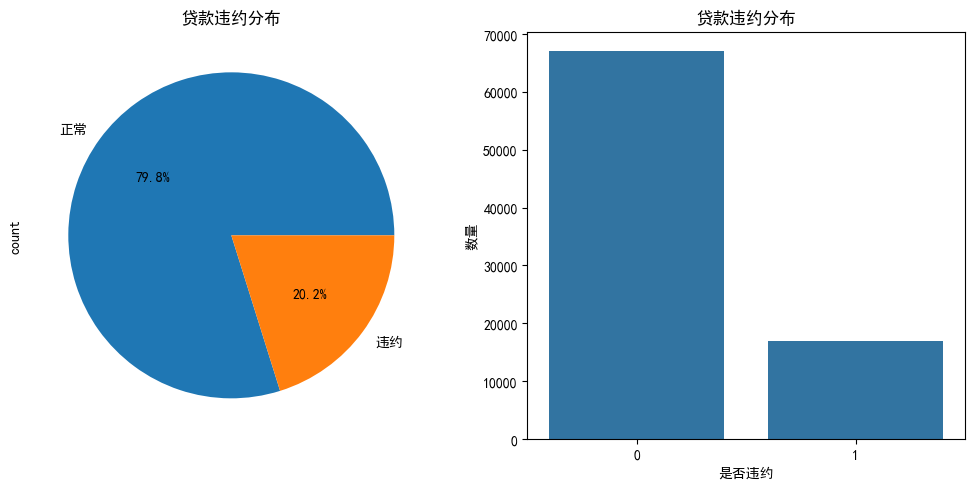

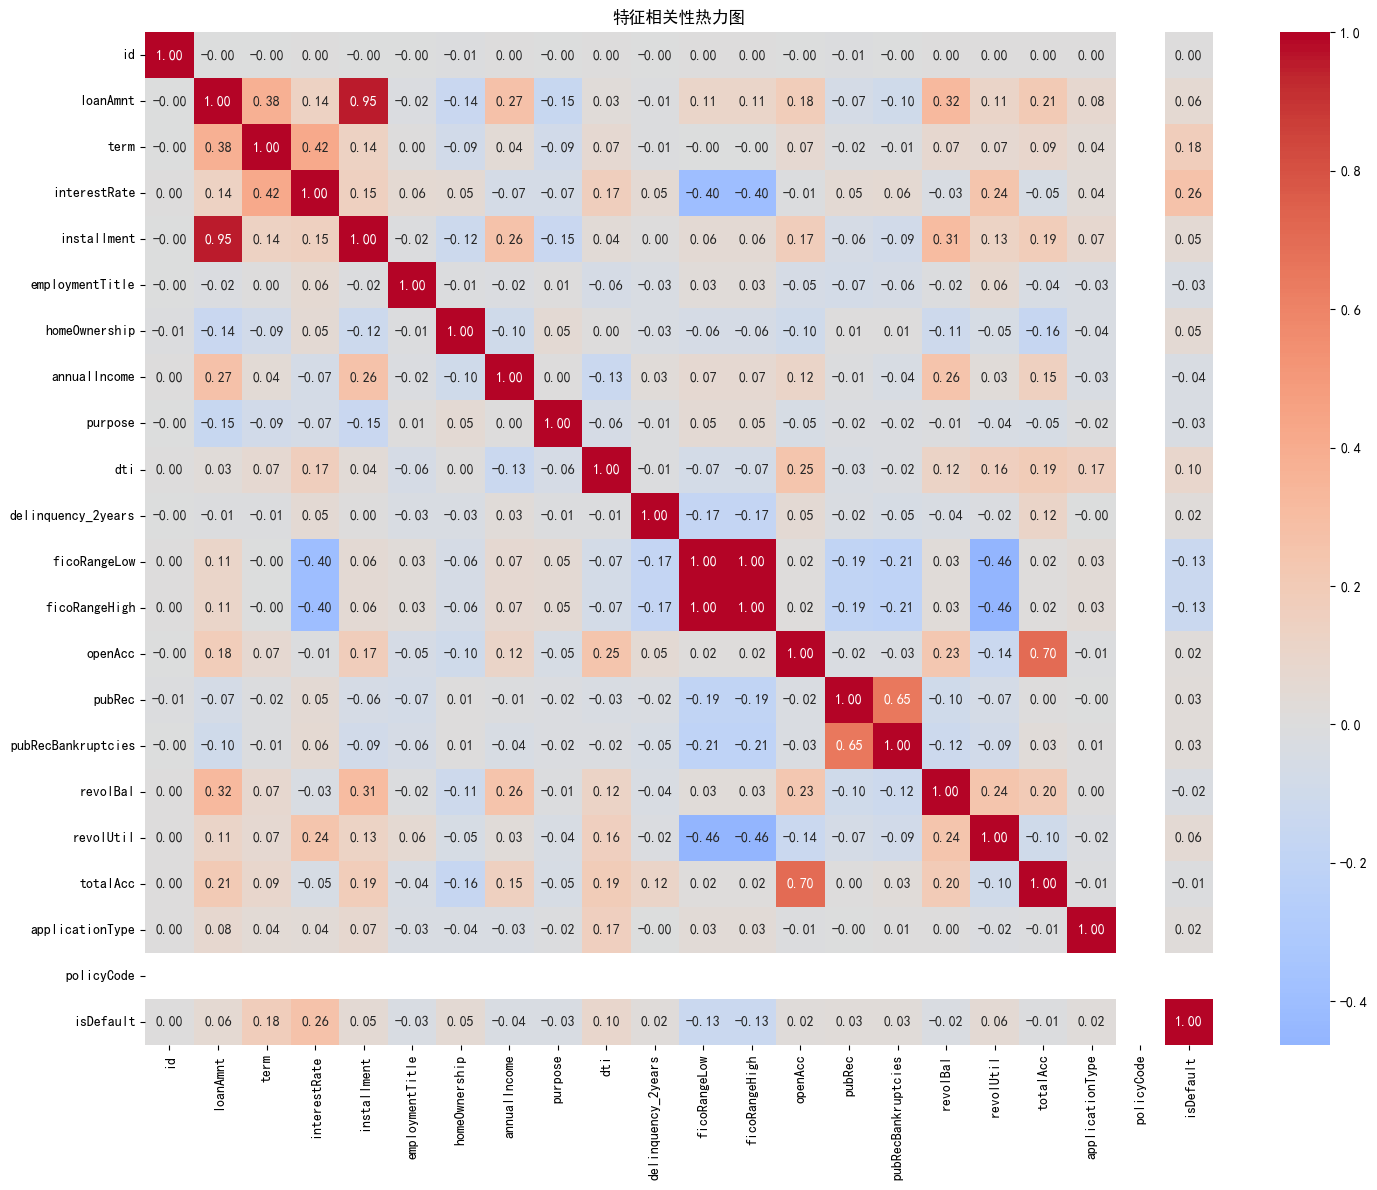


与违约最相关的前10个特征:
interestRate          0.259834
term                  0.178211
dti                   0.095507
loanAmnt              0.061447
revolUtil             0.056137
homeOwnership         0.050816
installment           0.046757
pubRec                0.027248
pubRecBankruptcies    0.026831
openAcc               0.022030
Name: isDefault, dtype: float64


In [3]:
# 第一步：宏观分析
# 1.1 分析目标变量(isDefault)的分布
plt.figure(figsize=(10, 5))

# 计算违约率
default_rate = df['isDefault'].mean() * 100
print(f"总体违约率: {default_rate:.2f}%")

# 绘制违约分布饼图
plt.subplot(121)
df['isDefault'].value_counts().plot(kind='pie', autopct='%1.1f%%', labels=['正常', '违约'])
plt.title('贷款违约分布')

# 绘制违约分布条形图
plt.subplot(122)
sns.countplot(data=df, x='isDefault')
plt.title('贷款违约分布')
plt.xlabel('是否违约')
plt.ylabel('数量')

plt.tight_layout()
plt.show()

# 1.2 分析数值特征相关性
# 选择数值型特征
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_features].corr()

# 绘制相关性热力图
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('特征相关性热力图')
plt.tight_layout()
plt.show()

# 打印与目标变量相关性最强的前10个特征
correlations_with_target = correlation_matrix['isDefault'].sort_values(ascending=False)
print("\n与违约最相关的前10个特征:")
print(correlations_with_target[1:11])  # 排除isDefault本身


C:\Users\YanShisan\AppData\Local\Temp\ipykernel_26344\1599863073.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = data.groupby('bins')['isDefault'].agg(['mean', 'count'])
C:\Users\YanShisan\AppData\Local\Temp\ipykernel_26344\1599863073.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = data.groupby('bins')['isDefault'].agg(['mean', 'count'])
C:\Users\YanShisan\AppData\Local\Temp\ipykernel_26344\1599863073.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavi

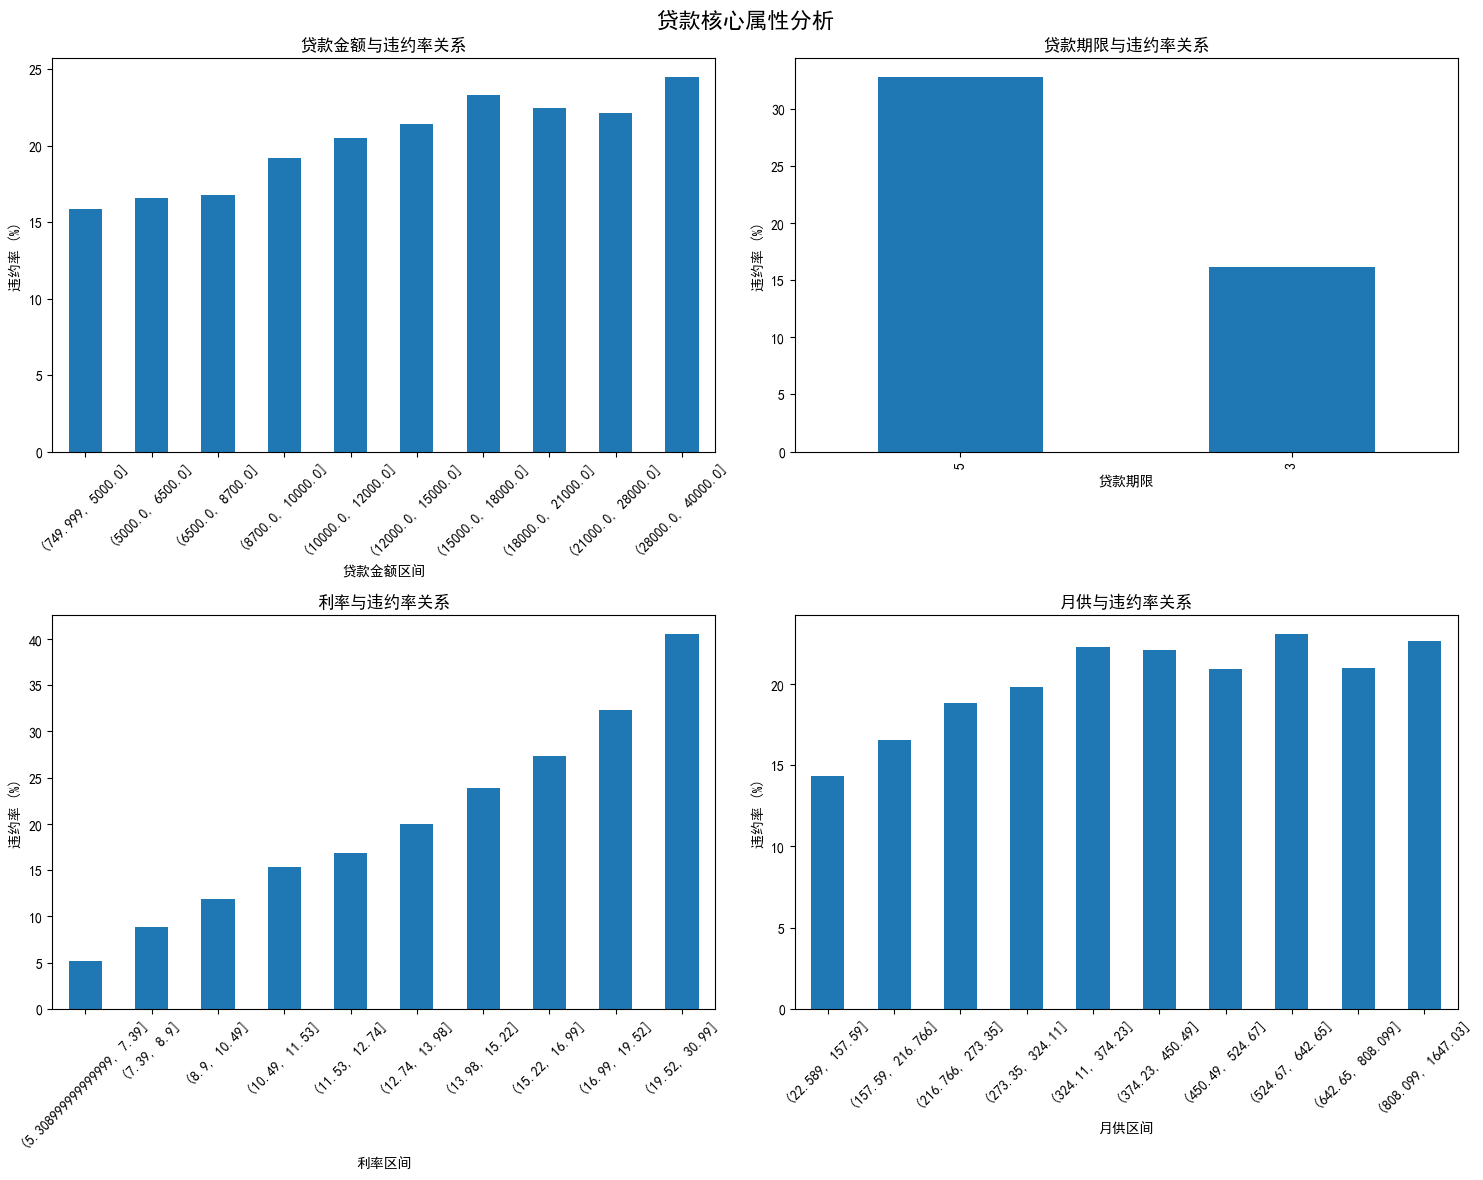

In [4]:
# 第二步：分组特征分析

# 创建一个通用的违约率计算函数
def calculate_default_rate(data, feature, bins=None, is_categorical=False):
    if is_categorical:
        default_rates = data.groupby(feature)['isDefault'].agg(['mean', 'count'])
        default_rates['mean'] = default_rates['mean'] * 100
        default_rates = default_rates.sort_values('mean', ascending=False)
    else:
        if bins is None:
            bins = 10
        data['bins'] = pd.qcut(data[feature], q=bins, duplicates='drop')
        default_rates = data.groupby('bins')['isDefault'].agg(['mean', 'count'])
        default_rates['mean'] = default_rates['mean'] * 100
        data.drop('bins', axis=1, inplace=True)
    return default_rates

# 2.1 贷款核心属性分析
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('贷款核心属性分析', fontsize=16)

# 贷款金额分析
default_rates = calculate_default_rate(df, 'loanAmnt')
ax = axes[0, 0]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('贷款金额与违约率关系')
ax.set_xlabel('贷款金额区间')
ax.set_ylabel('违约率 (%)')
ax.tick_params(axis='x', rotation=45)

# 贷款期限分析
default_rates = calculate_default_rate(df, 'term', is_categorical=True)
ax = axes[0, 1]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('贷款期限与违约率关系')
ax.set_xlabel('贷款期限')
ax.set_ylabel('违约率 (%)')

# 利率分析
default_rates = calculate_default_rate(df, 'interestRate')
ax = axes[1, 0]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('利率与违约率关系')
ax.set_xlabel('利率区间')
ax.set_ylabel('违约率 (%)')
ax.tick_params(axis='x', rotation=45)

# 月供分析
default_rates = calculate_default_rate(df, 'installment')
ax = axes[1, 1]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('月供与违约率关系')
ax.set_xlabel('月供区间')
ax.set_ylabel('违约率 (%)')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


C:\Users\YanShisan\AppData\Local\Temp\ipykernel_26344\1599863073.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = data.groupby('bins')['isDefault'].agg(['mean', 'count'])
C:\Users\YanShisan\AppData\Local\Temp\ipykernel_26344\1599863073.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = data.groupby('bins')['isDefault'].agg(['mean', 'count'])
C:\Users\YanShisan\AppData\Local\Temp\ipykernel_26344\1599863073.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavi

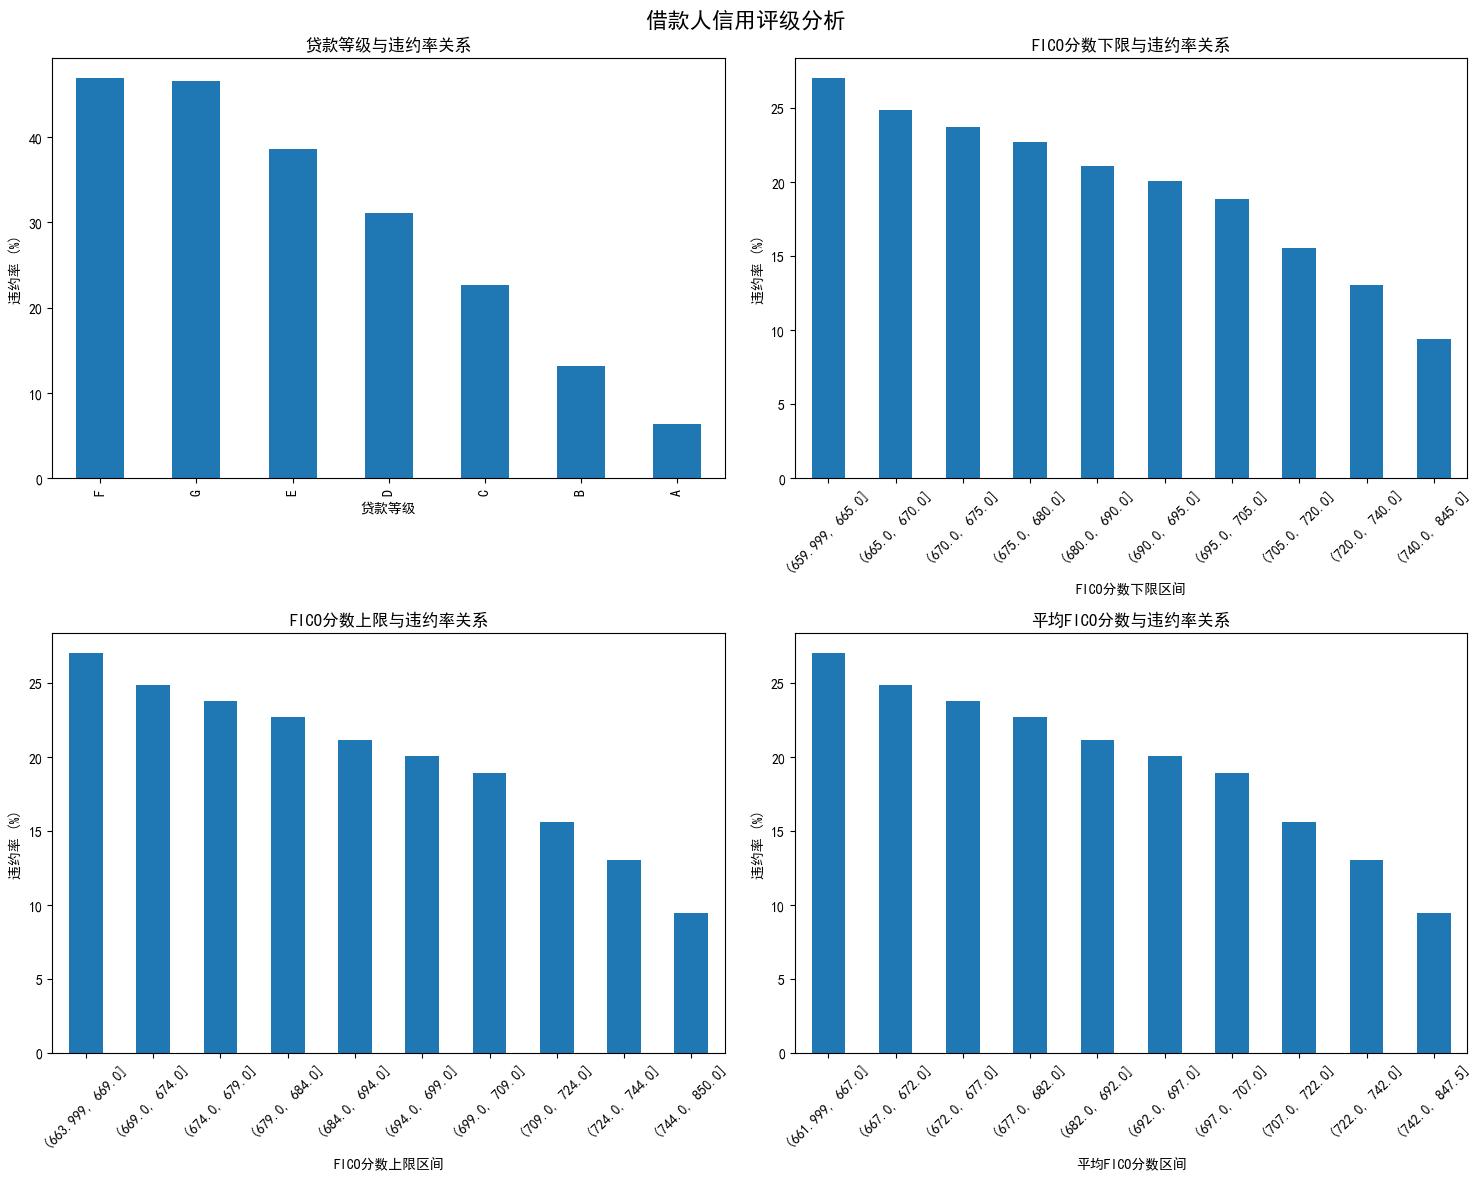

C:\Users\YanShisan\AppData\Local\Temp\ipykernel_26344\1599863073.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = data.groupby('bins')['isDefault'].agg(['mean', 'count'])
C:\Users\YanShisan\AppData\Local\Temp\ipykernel_26344\1599863073.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = data.groupby('bins')['isDefault'].agg(['mean', 'count'])


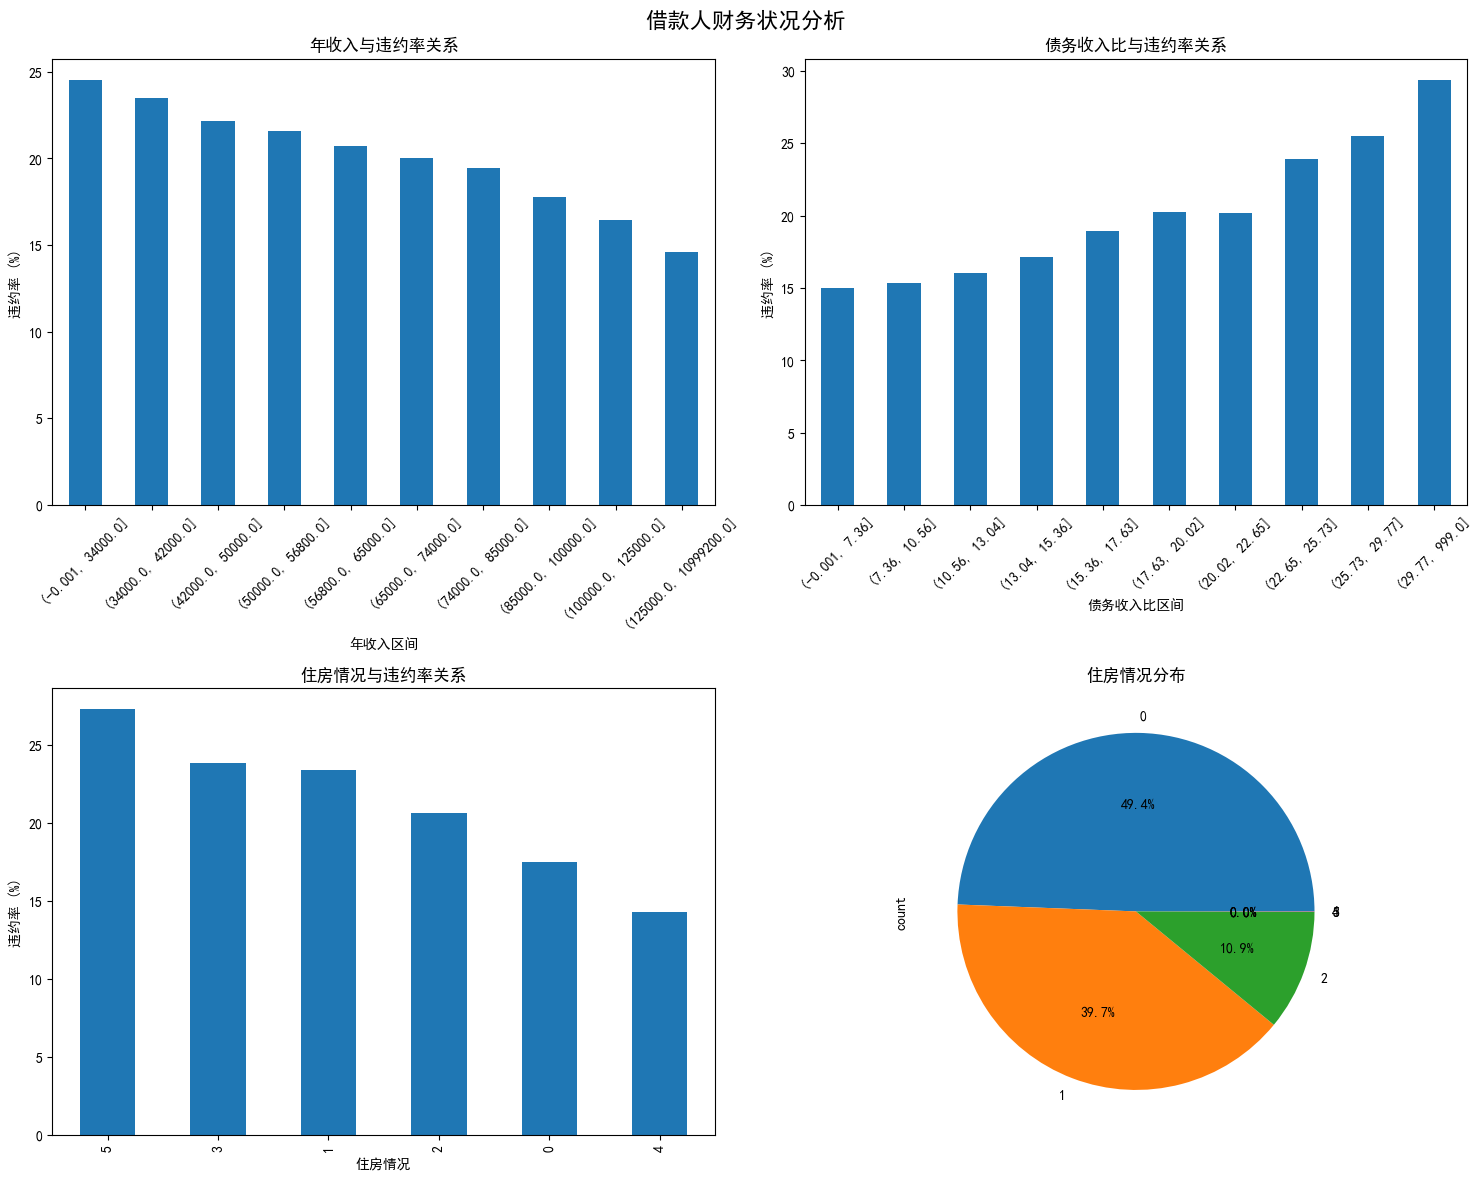

In [5]:
# 2.2 借款人信用评级分析
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('借款人信用评级分析', fontsize=16)

# 贷款等级分析
default_rates = calculate_default_rate(df, 'grade', is_categorical=True)
ax = axes[0, 0]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('贷款等级与违约率关系')
ax.set_xlabel('贷款等级')
ax.set_ylabel('违约率 (%)')

# FICO分数下限分析
default_rates = calculate_default_rate(df, 'ficoRangeLow')
ax = axes[0, 1]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('FICO分数下限与违约率关系')
ax.set_xlabel('FICO分数下限区间')
ax.set_ylabel('违约率 (%)')
ax.tick_params(axis='x', rotation=45)

# FICO分数上限分析
default_rates = calculate_default_rate(df, 'ficoRangeHigh')
ax = axes[1, 0]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('FICO分数上限与违约率关系')
ax.set_xlabel('FICO分数上限区间')
ax.set_ylabel('违约率 (%)')
ax.tick_params(axis='x', rotation=45)

# 平均FICO分数分析
df['avg_fico'] = (df['ficoRangeLow'] + df['ficoRangeHigh']) / 2
default_rates = calculate_default_rate(df, 'avg_fico')
ax = axes[1, 1]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('平均FICO分数与违约率关系')
ax.set_xlabel('平均FICO分数区间')
ax.set_ylabel('违约率 (%)')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2.3 借款人财务状况分析
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('借款人财务状况分析', fontsize=16)

# 年收入分析
default_rates = calculate_default_rate(df, 'annualIncome')
ax = axes[0, 0]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('年收入与违约率关系')
ax.set_xlabel('年收入区间')
ax.set_ylabel('违约率 (%)')
ax.tick_params(axis='x', rotation=45)

# 债务收入比分析
default_rates = calculate_default_rate(df, 'dti')
ax = axes[0, 1]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('债务收入比与违约率关系')
ax.set_xlabel('债务收入比区间')
ax.set_ylabel('违约率 (%)')
ax.tick_params(axis='x', rotation=45)

# 住房情况分析
default_rates = calculate_default_rate(df, 'homeOwnership', is_categorical=True)
ax = axes[1, 0]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('住房情况与违约率关系')
ax.set_xlabel('住房情况')
ax.set_ylabel('违约率 (%)')

# 住房情况分布
ax = axes[1, 1]
df['homeOwnership'].value_counts().plot(kind='pie', ax=ax, autopct='%1.1f%%')
ax.set_title('住房情况分布')

plt.tight_layout()
plt.show()


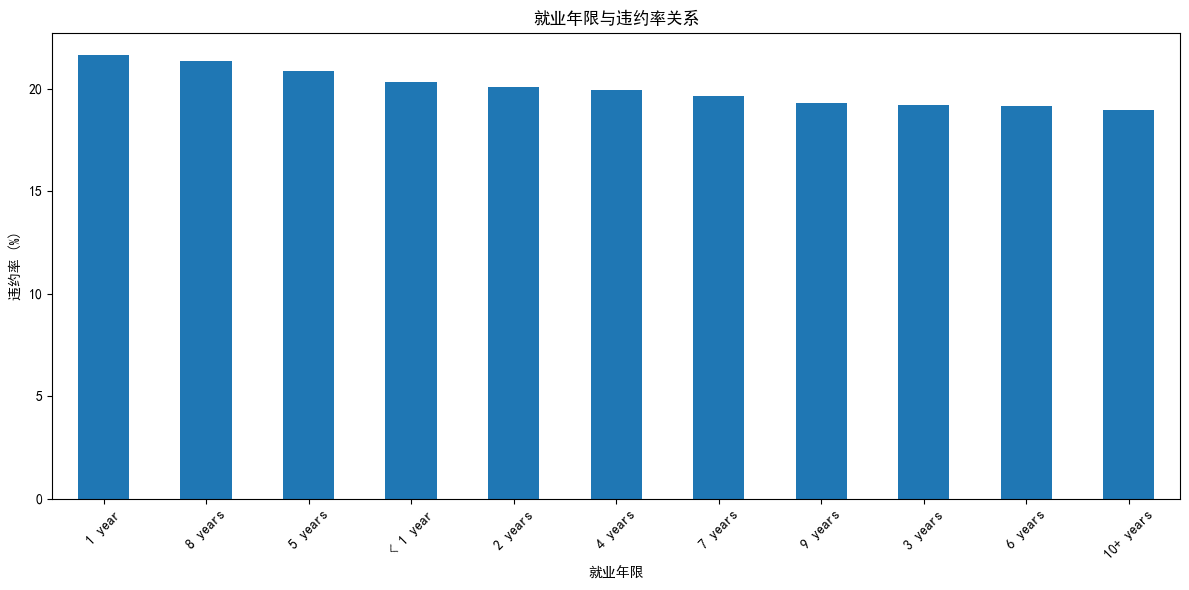

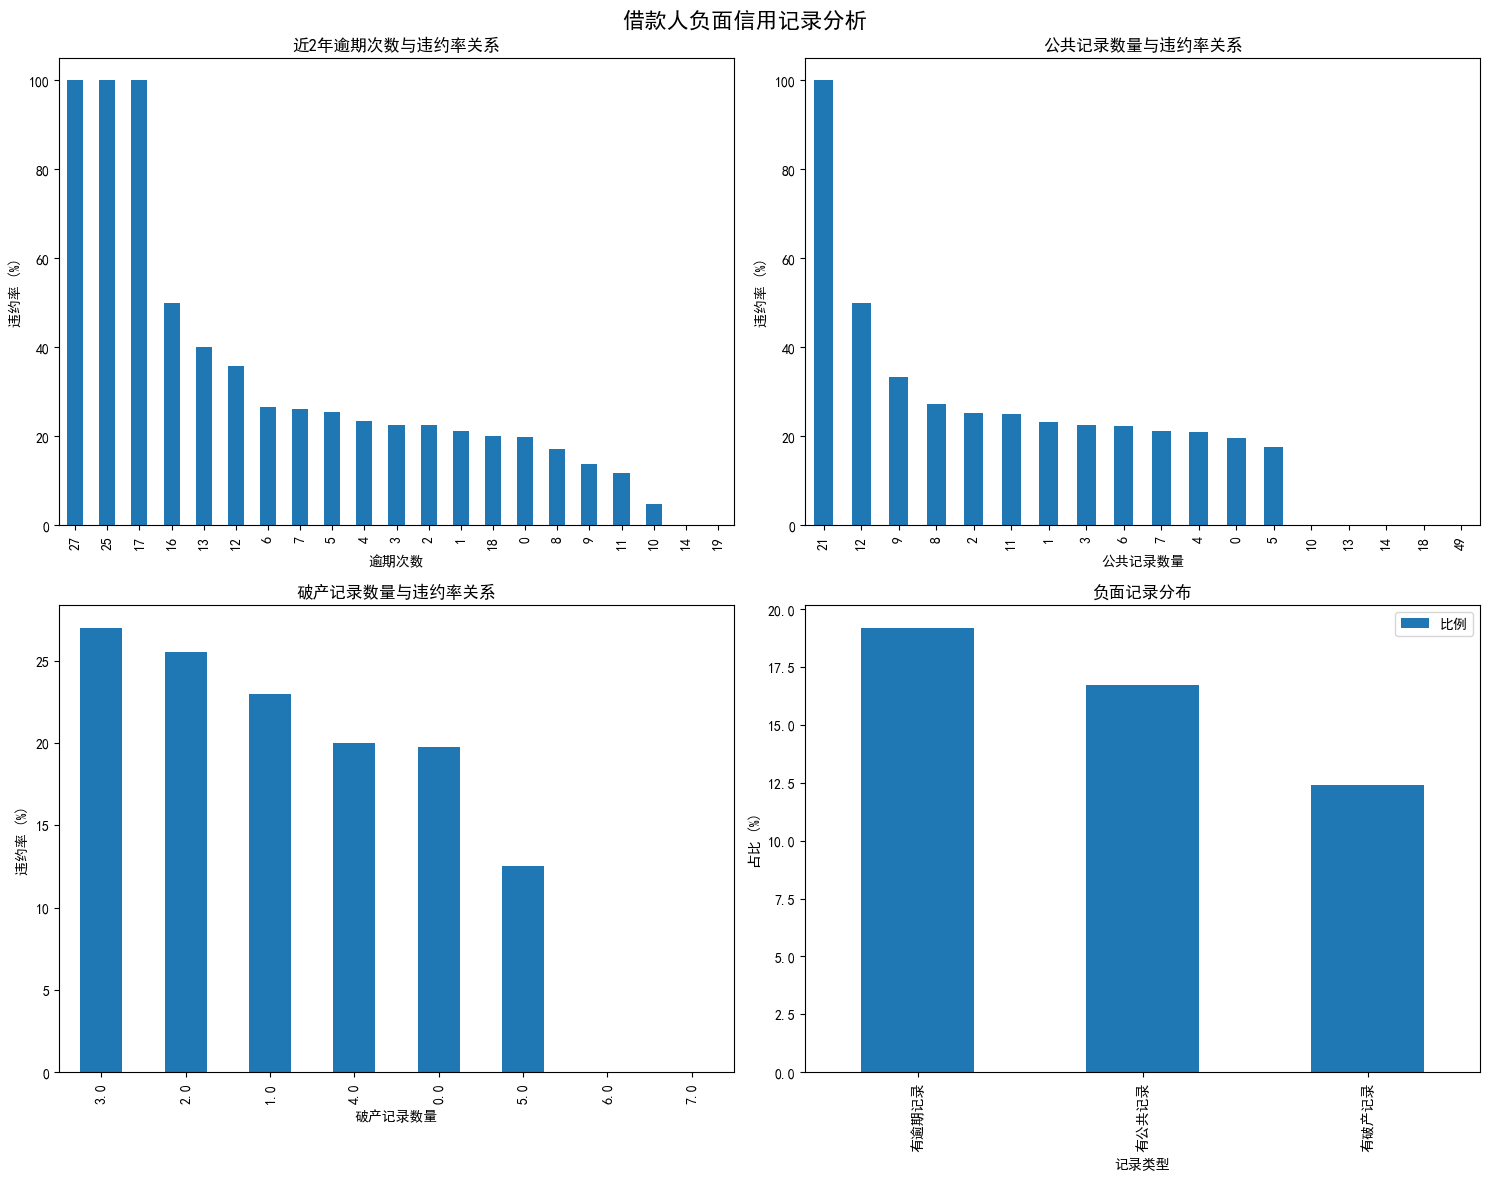

C:\Users\YanShisan\AppData\Local\Temp\ipykernel_26344\1599863073.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = data.groupby('bins')['isDefault'].agg(['mean', 'count'])
C:\Users\YanShisan\AppData\Local\Temp\ipykernel_26344\1599863073.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = data.groupby('bins')['isDefault'].agg(['mean', 'count'])
C:\Users\YanShisan\AppData\Local\Temp\ipykernel_26344\1599863073.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavi

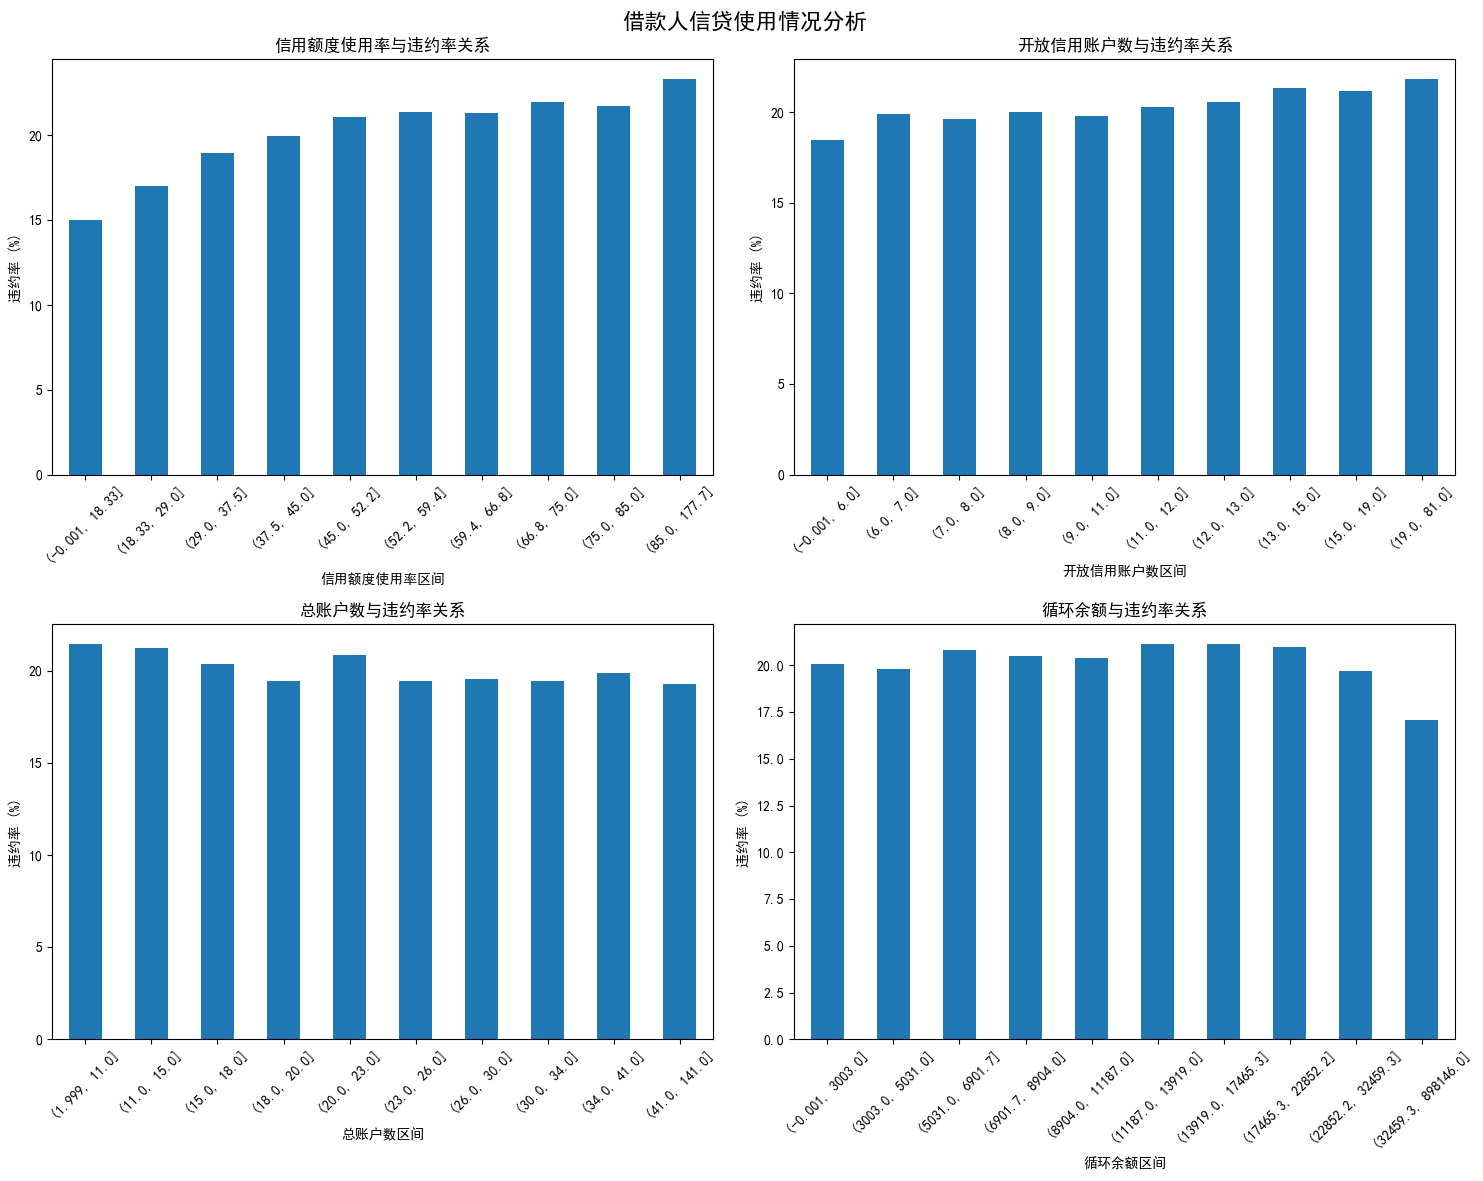

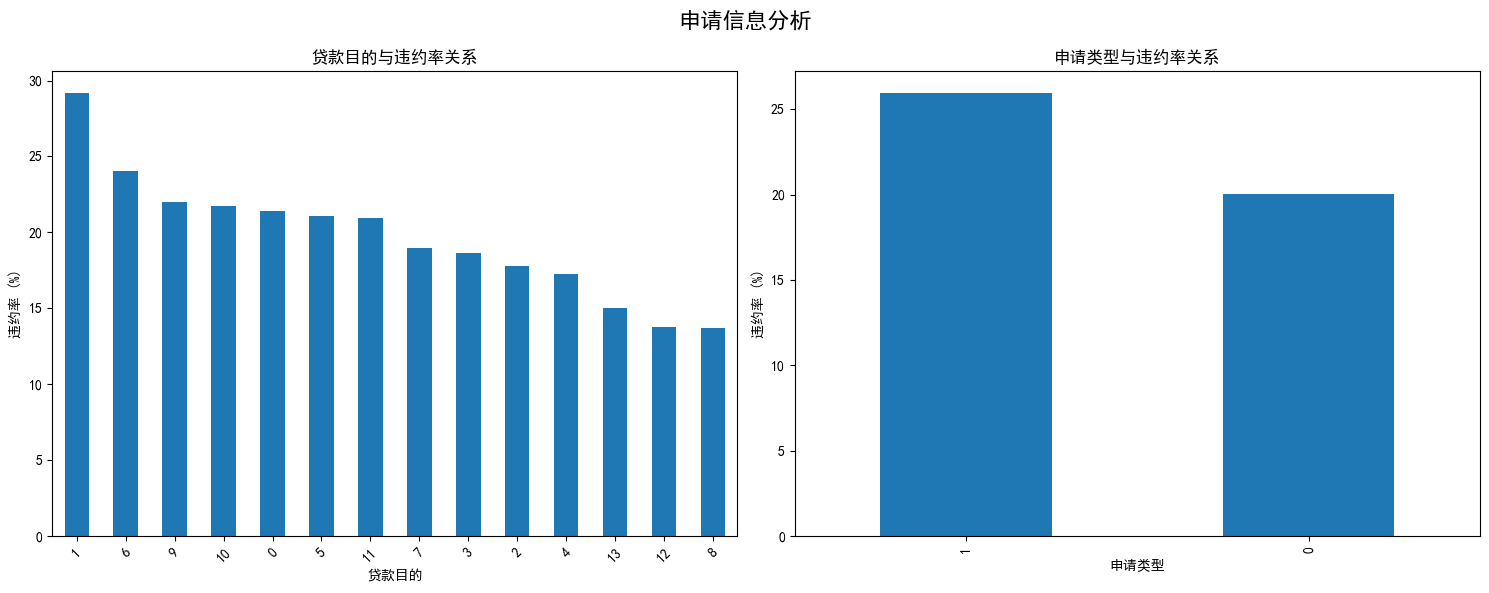

In [6]:
# 2.4 借款人就业情况分析
plt.figure(figsize=(12, 6))

# 就业年限分析
default_rates = calculate_default_rate(df, 'employmentLength', is_categorical=True)
default_rates['mean'].plot(kind='bar')
plt.title('就业年限与违约率关系')
plt.xlabel('就业年限')
plt.ylabel('违约率 (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2.5 借款人负面信用记录分析
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('借款人负面信用记录分析', fontsize=16)

# 近2年逾期次数分析
default_rates = calculate_default_rate(df, 'delinquency_2years', is_categorical=True)
ax = axes[0, 0]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('近2年逾期次数与违约率关系')
ax.set_xlabel('逾期次数')
ax.set_ylabel('违约率 (%)')

# 公共记录数量分析
default_rates = calculate_default_rate(df, 'pubRec', is_categorical=True)
ax = axes[0, 1]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('公共记录数量与违约率关系')
ax.set_xlabel('公共记录数量')
ax.set_ylabel('违约率 (%)')

# 破产记录数量分析
default_rates = calculate_default_rate(df, 'pubRecBankruptcies', is_categorical=True)
ax = axes[1, 0]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('破产记录数量与违约率关系')
ax.set_xlabel('破产记录数量')
ax.set_ylabel('违约率 (%)')

# 负面记录分布
ax = axes[1, 1]
negative_records = pd.DataFrame({
    '有逾期记录': (df['delinquency_2years'] > 0).mean() * 100,
    '有公共记录': (df['pubRec'] > 0).mean() * 100,
    '有破产记录': (df['pubRecBankruptcies'] > 0).mean() * 100
}, index=['比例']).T
negative_records.plot(kind='bar', ax=ax)
ax.set_title('负面记录分布')
ax.set_xlabel('记录类型')
ax.set_ylabel('占比 (%)')

plt.tight_layout()
plt.show()

# 2.6 借款人信贷使用情况分析
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('借款人信贷使用情况分析', fontsize=16)

# 信用额度使用率分析
default_rates = calculate_default_rate(df, 'revolUtil')
ax = axes[0, 0]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('信用额度使用率与违约率关系')
ax.set_xlabel('信用额度使用率区间')
ax.set_ylabel('违约率 (%)')
ax.tick_params(axis='x', rotation=45)

# 开放信用账户数分析
default_rates = calculate_default_rate(df, 'openAcc')
ax = axes[0, 1]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('开放信用账户数与违约率关系')
ax.set_xlabel('开放信用账户数区间')
ax.set_ylabel('违约率 (%)')
ax.tick_params(axis='x', rotation=45)

# 总账户数分析
default_rates = calculate_default_rate(df, 'totalAcc')
ax = axes[1, 0]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('总账户数与违约率关系')
ax.set_xlabel('总账户数区间')
ax.set_ylabel('违约率 (%)')
ax.tick_params(axis='x', rotation=45)

# 循环余额分析
default_rates = calculate_default_rate(df, 'revolBal')
ax = axes[1, 1]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('循环余额与违约率关系')
ax.set_xlabel('循环余额区间')
ax.set_ylabel('违约率 (%)')
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2.7 申请信息分析
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('申请信息分析', fontsize=16)

# 贷款目的分析
default_rates = calculate_default_rate(df, 'purpose', is_categorical=True)
ax = axes[0]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('贷款目的与违约率关系')
ax.set_xlabel('贷款目的')
ax.set_ylabel('违约率 (%)')
ax.tick_params(axis='x', rotation=45)

# 申请类型分析
default_rates = calculate_default_rate(df, 'applicationType', is_categorical=True)
ax = axes[1]
default_rates['mean'].plot(kind='bar', ax=ax)
ax.set_title('申请类型与违约率关系')
ax.set_xlabel('申请类型')
ax.set_ylabel('违约率 (%)')

plt.tight_layout()
plt.show()
